In [1]:
import os
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import torch
import dolfin
from dolfin import *
#import mshr
import pickle

/home/haltmayermarc/anaconda3/envs/fenics/lib/python3.11/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):


In [2]:
num_h=40
g1 = 0.0
g2 = 0.0

#  Length and Height.
Le = 1.0
He = 1.0

#  The body force vector f = (fx,fy).
np.random.seed(5)
m0, m1, m2, m3 = 0.5*np.random.rand(4)
n0, n1, n2, n3 = (1/15)*np.pi*(np.random.rand(4))
f = Expression ( ( "m0*sin(n0*x[0])+m1*sin(n1*x[1])", "m2*cos(n2*x[0])+m3*cos(n3*x[1])" ), degree=5, m0=m0, m1=m1, m2=m2, m3=m3, n0=n0, n1=n1, n2=n2, n3=n3 )

#  Specify the boundary conditions.
def LowerBoundary ( x, on_boundary ):
  return x[1] < DOLFIN_EPS and on_boundary

SlipRate = Expression ( ( "g1", "g2" ), degree=3, g1=g1, g2=g2)

#  Define the mesh, using 3 cells in the X and Y direction.
mesh = RectangleMesh ( Point(0.0, 0.0), Point(Le, He), num_h, num_h)

#  Define the function spaces:
#    Velocity: piecewise quadratic vector.
#    Pressure: piecewise linear scalar.
V = VectorElement('CG', triangle, 2)
Q = FiniteElement('CG', triangle, 1)
TH = V * Q
W = FunctionSpace(mesh, TH)

#  Define the Dirichlet condition at the base of the glacier.
bc = DirichletBC ( W.sub ( 0 ), SlipRate, LowerBoundary )

#  Define the variational problem: a(u,v) = L(v).
w = Function(W)
(u, p) = split(w)
(v, q) = TestFunctions (W)

#  Material viscosity, Pa-sec.
mu=0.1
a = ( 
   mu * inner(grad(v), grad(u)) 
  - p*div(v) - q*div(u) 
  + dot(dot(grad(u), u), v)
  ) * dx
l = inner ( v, f ) * dx

F = a - l

#  Solution.
J = derivative(F, w)
solve ( F == 0, w, bc, J = J )

sol_w = torch.tensor(w.vector()[:])

#  Split the mixed solution to recover velocity and pressure.
(u, p) = w.split(deepcopy=True)

sol_u1=torch.tensor(u.sub(0, deepcopy=True).vector()[:])
sol_u2=torch.tensor(u.sub(1,deepcopy=True).vector()[:])
sol_p=torch.tensor(p.vector()[:])
print(torch.min(sol_p),torch.max(sol_p))
print(sol_u1.shape, sol_u2.shape, sol_p.shape)

/home/haltmayermarc/anaconda3/envs/fenics/lib/python3.11/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.077e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 9.529e-03 (tol = 1.000e-10) r (rel) = 1.180e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.350e-04 (tol = 1.000e-10) r (rel) = 1.158e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.035e-03 (tol = 1.000e-10) r (rel) = 1.282e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.479e-05 (tol = 1.000e-10) r (rel) = 1.831e-03 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 3.584e-07 (tol = 1.000e-10) r (rel) = 4.437e-05 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 6.025e-11 (tol = 1.000e-10) r (rel) = 7.459e-09 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.
tensor(-0.4160, dtype=torch.float64) tensor(0.0586, dtype=torch.float64)
torch.Size([6561]) torch.Size([6561]) torch.Size([1681])


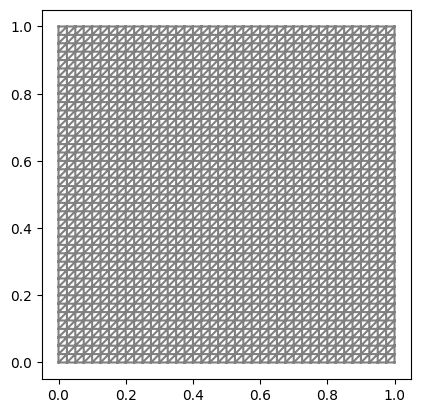

In [3]:
plot(mesh)

In [4]:
pos_u=W.sub(0).sub(0).collapse().tabulate_dof_coordinates()
pos_u1=W.sub(0).sub(0).collapse().tabulate_dof_coordinates()
pos_u2=W.sub(0).sub(1).collapse().tabulate_dof_coordinates()
pos_p=W.sub(1).collapse().tabulate_dof_coordinates()

In [5]:
pos_all=W.tabulate_dof_coordinates()
idx_u1=W.sub(0).sub(0).dofmap().dofs()
idx_u2=W.sub(0).sub(1).dofmap().dofs()
idx_p=W.sub(1).dofmap().dofs()
idx_sol = [idx_u1, idx_u2, idx_p]

### Check ordering

In [6]:
print(np.abs(pos_all[idx_u1] - pos_u1).sum())
print(np.abs(pos_all[idx_u2] - pos_u2).sum())
print(np.abs(pos_all[idx_p] - pos_p).sum())
print(np.abs(pos_u1 - pos_u2).sum())

same_as_sets = set(map(tuple, pos_p)) == set(map(tuple, pos_all[idx_p]))
print("Arrays contain the same 2D elements (unordered):", same_as_sets)
same_as_vectors = np.array_equal(pos_p, pos_all[idx_p])
print("Arrays are identical:", same_as_vectors)

0.0
0.12499999999999994
0.10000000000000003
0.0
Arrays contain the same 2D elements (unordered): True
Arrays are identical: False


In [7]:
row_to_index_u1 = {tuple(row): i for i, row in enumerate(pos_u1)}
row_to_index_u2 = {tuple(row): i for i, row in enumerate(pos_u2)}
row_to_index_p = {tuple(row): i for i, row in enumerate(pos_p)}

perm_u1 = np.array([row_to_index_u1[tuple(row)] for row in pos_all[idx_u1]])
perm_u2 = np.array([row_to_index_u2[tuple(row)] for row in pos_all[idx_u2]])
perm_p = np.array([row_to_index_p[tuple(row)] for row in pos_all[idx_p]])

pos_u1_ordered = pos_u1[perm_u1]
pos_u2_ordered = pos_u2[perm_u2]
pos_p_ordered = pos_p[perm_p]
print("Are all DOFs ordered the same way now?")
print("u1", np.array_equal(pos_u1_ordered, pos_all[idx_u1]))
print("u2", np.array_equal(pos_u2_ordered, pos_all[idx_u2]))
print("p", np.array_equal(pos_p_ordered, pos_all[idx_p]))

print(np.abs(pos_all[idx_u1] - pos_u1_ordered).sum())
print(np.abs(pos_all[idx_u2] - pos_u2_ordered).sum())
print(np.abs(pos_all[idx_p] - pos_p_ordered).sum())

Are all DOFs ordered the same way now?
u1 True
u2 True
p True
0.0
0.0
0.0


In [8]:
sol_u1_ordered = sol_u1[perm_u1]
sol_u2_ordered = sol_u2[perm_u2]
sol_p_ordered = sol_p[perm_p]

### Assemble A, B1 and B2

In [9]:
#  Length and Height.
Le = 1.0
He = 1.0

#  The body force vector f = (fx,fy).
np.random.seed(5)
m0, m1, m2, m3 = 0.5*np.random.rand(4)
n0, n1, n2, n3 = (1/15)*np.pi*(np.random.rand(4))
f = Expression ( ( "m0*sin(n0*x[0])+m1*sin(n1*x[1])", "m2*cos(n2*x[0])+m3*cos(n3*x[1])" ), degree=5, m0=m0, m1=m1, m2=m2, m3=m3, n0=n0, n1=n1, n2=n2, n3=n3 )

#  Specify the boundary conditions.
def LowerBoundary ( x, on_boundary ):
  return x[1] < DOLFIN_EPS and on_boundary

SlipRate = Expression ( ( "g1", "g2" ), degree=3, g1=g1, g2=g2)

#  Define the mesh, using 3 cells in the X and Y direction.
mesh = RectangleMesh ( Point(0.0, 0.0), Point(Le, He), num_h, num_h)

#  Define the function spaces:
#  Velocity: piecewise quadratic vector.
#  Pressure: piecewise linear scalar.
V = VectorElement('CG', triangle, 2)
Q = FiniteElement('CG', triangle, 1)
TH = V * Q
W = FunctionSpace(mesh, TH)

#  Define the Dirichlet condition at the base of the glacier.
bc = DirichletBC ( W.sub ( 0 ), SlipRate, LowerBoundary )

#  Define the variational problem: a(u,v) = L(v).
w = Function(W)
(u, p) = TrialFunctions (W)
(v, q) = TestFunctions (W)

#  Material viscosity, Pa-sec.
mu=0.1
a = ( 
   mu * inner(grad(v), grad(u)) 
  - p*div(v) - q*div(u) ) * dx

b1 = ( 
  dot(dot(grad(u), Constant((1.0,0.0))), v) 
  ) * dx

b2 = ( 
  dot(dot(grad(u), Constant((0.0,1.0))), v) 
  ) * dx

l = inner ( v, f ) * dx

#  Matrix assembly.
## With B(coeff)=coeff[u]*B1+coeff[v]*B2,
## we will do (A+B(coeff)) @ coeff = load_vector
## Therefore, we can give the loss | (A+B(coeff)) @ coeff -load_vector |^2
A = assemble(a)
bc.apply(A)
A = A.array()

B1 = assemble(b1)
B1 = B1.array()

B2 = assemble(b2)
B2 = B2.array()

L = assemble(l)
bc.apply(L)
load_vector = L.get_local()

In [10]:
A=torch.tensor(A, dtype=torch.float64)
B1=torch.tensor(B1, dtype=torch.float64)
B2=torch.tensor(B2, dtype=torch.float64)
load_vector=torch.tensor(load_vector, dtype=torch.float64)

In [11]:
A.shape

torch.Size([14803, 14803])

In [43]:
print(A.shape)
print("Min:", torch.min(A).item())
print("Max:", torch.max(A).item())

torch.Size([3803, 3803])
Min: -0.1333333333333347
Max: 1.0


In [48]:
U, S, Vh = torch.linalg.svd(B2)
cond_num = S.max() / S.min()

print("Condition number:", cond_num.item())

Condition number: 1.4103960229021908e+18


In [15]:
B1.shape
print("Min:", torch.min(B1).item())
print("Max:", torch.max(B1).item())

Min: -0.006666666666666677
Max: 0.00666666666666671


In [38]:
p=pos_all
re_idx_pos_u = np.lexsort((pos_u[:,0], pos_u[:,1]))
re_idx_pos_p = np.lexsort((pos_p[:,0], pos_p[:,1]))
re_idx_u1 = np.lexsort((p[idx_sol[0]][:,0], p[idx_sol[0]][:,1]))
re_idx_u2 = np.lexsort((p[idx_sol[1]][:,0], p[idx_sol[1]][:,1]))
re_idx_p = np.lexsort((p[idx_sol[2]][:,0], p[idx_sol[2]][:,1])) 

In [39]:
u_answer=torch.zeros(len(idx_sol[0])+len(idx_sol[1])+len(idx_sol[2]), dtype=torch.float64)
u_answer[torch.tensor(idx_sol[0])[re_idx_u1]]=sol_u1[re_idx_pos_u]
u_answer[torch.tensor(idx_sol[1])[re_idx_u2]]=sol_u2[re_idx_pos_u]
u_answer[torch.tensor(idx_sol[2])[re_idx_p]]=sol_p[re_idx_pos_p]

In [ ]:
diag_vector_1 = torch.zeros(B1.shape[0], dtype=u_answer.dtype, device=u_answer.device)
diag_vector_1[idx_sol[0]] = u_answer[idx_sol[0]]
diag_vector_1[idx_sol[1]] = u_answer[idx_sol[0]]

diag_vector_2 = torch.zeros(B2.shape[0], dtype=u_answer.dtype, device=u_answer.device)
diag_vector_2[idx_sol[0]] = u_answer[idx_sol[1]]
diag_vector_2[idx_sol[1]] = u_answer[idx_sol[1]]

convection = diag_vector_1 * (B1 @ u_answer) + diag_vector_2 * (B2 @ u_answer)
linear_term = A @ u_answer
LHS_2 =  convection + linear_term
RHS = load_vector
torch.abs(LHS_2-RHS).mean() / torch.abs(RHS).mean()

In [40]:
matrix_u1=torch.zeros_like(B1)
matrix_u1[idx_sol[0],idx_sol[0]]=u_answer[idx_sol[0]]
matrix_u1[idx_sol[1],idx_sol[1]]=u_answer[idx_sol[0]]

matrix_u2=torch.zeros_like(B1)
matrix_u2[idx_sol[0],idx_sol[0]]=u_answer[idx_sol[1]]
matrix_u2[idx_sol[1],idx_sol[1]]=u_answer[idx_sol[1]]

B=matrix_u1@B1+matrix_u2@B2

LHS = (A+B)@u_answer.reshape(-1,1)
LHS = LHS.reshape(-1)
RHS = load_vector
torch.abs(LHS-RHS).mean() / torch.abs(RHS).mean()

tensor(0.0017, dtype=torch.float64)

### Write down nonlinear equation using element-wise vector products

In [41]:
diag_vector_1 = torch.zeros(B1.shape[0], dtype=u_answer.dtype, device=u_answer.device)
diag_vector_1[idx_sol[0]] = u_answer[idx_sol[0]]
diag_vector_1[idx_sol[1]] = u_answer[idx_sol[0]]

diag_vector_2 = torch.zeros(B2.shape[0], dtype=u_answer.dtype, device=u_answer.device)
diag_vector_2[idx_sol[0]] = u_answer[idx_sol[1]]
diag_vector_2[idx_sol[1]] = u_answer[idx_sol[1]]

convection = diag_vector_1 * (B1 @ u_answer) + diag_vector_2 * (B2 @ u_answer)
linear_term = A @ u_answer
LHS_2 =  convection + linear_term
torch.abs(LHS_2-RHS).mean() / torch.abs(RHS).mean()

tensor(0.0017, dtype=torch.float64)

### Use Newton's method to solve the system

\begin{equation*}
A \alpha + [\alpha_u, \alpha_v , 0] \ast B_1 \alpha + [\alpha_u, \alpha_v , 0] \ast B_2 \alpha = 0
\end{equation*}

In [42]:
import torch

def newton_solve_nonlinear_system(
    A, B1, B2, load_vector, idx_sol, 
    u0=None, max_iters=50, rtol=1e-10, atol=1e-12, 
    line_search=True, ls_shrink=0.5, ls_min_alpha=1e-6, verbose=True
):
    device = A.device
    dtype = A.dtype
    N = A.shape[0]

    # Normalize indices to tensors on device
    def _as_idx(x):
        if isinstance(x, torch.Tensor):
            return x.to(device=device)
        return torch.as_tensor(x, device=device, dtype=torch.long)

    # Accept either 2 or 3 lists in idx_sol; we only need the first two (u1, u2) for diag rules you showed
    idx_u1 = _as_idx(idx_sol[0])
    idx_u2 = _as_idx(idx_sol[1])

    # Initial guess
    if u0 is None:
        u = torch.zeros(N, dtype=dtype, device=device, requires_grad=True)
    else:
        u = u0.detach().to(device=device, dtype=dtype).requires_grad_(True)

    def residual(u_vec):
        # Build diag_vector_1 and diag_vector_2 from u
        d1 = torch.zeros_like(u_vec)
        d2 = torch.zeros_like(u_vec)

        d1.index_copy_(0, idx_u1, u_vec.index_select(0, idx_u1))
        d1.index_copy_(0, idx_u2, u_vec.index_select(0, idx_u1))

        
        d2.index_copy_(0, idx_u1, u_vec.index_select(0, idx_u2))
        d2.index_copy_(0, idx_u2, u_vec.index_select(0, idx_u2))

        # Compute the convection term
        conv = d1 * (B1 @ u_vec) + d2 * (B2 @ u_vec)

        # Compute the linear term
        lin  = A @ u_vec

        return lin + conv - load_vector

    # Norm helper
    def norm(x):
        return torch.linalg.norm(x)

    # Stopping threshold
    rhs_norm = max(norm(load_vector).item(), 1.0)
    target_tol = max(atol, rtol * rhs_norm)

    history = []

    for it in range(1, max_iters + 1):
        
        err = residual(u)
        err_norm = norm(err).item()
        history.append(err_norm)

        if verbose:
            print(f"[Newton] iter {it:02d}  ||res||={err_norm:.3e}  tol={target_tol:.3e}")

        if err_norm <= target_tol:
            if verbose:
                print("[Newton] Converged by residual.")
            return u.detach(), {"converged": True, "iters": it, "res_norm": err_norm, "history": history}

        # Jacobian via autograd
        with torch.enable_grad():
            def _err_for_jac(x):
                return residual(x)

            J = torch.autograd.functional.jacobian(_err_for_jac, u, create_graph=False, vectorize=True)  # [N,N]

        # Solve for Newton step: J * du = -err
        try:
            du = torch.linalg.solve(J, -err)
        except torch.linalg.LinAlgError:
            # Fallback to least-squares if singular
            du, *_ = torch.linalg.lstsq(J, -err.unsqueeze(1))
            du = du.squeeze(1)

        step_norm = norm(du).item()

        # Line search (backtracking) to ensure residual decreases
        alpha = 1.0
        if line_search:
            err_norm_curr = err_norm
            while alpha >= ls_min_alpha:
                u_trial = (u + alpha * du).detach().requires_grad_(True)
                err_trial = residual(u_trial)
                if norm(err_trial) < err_norm_curr:
                    u = u_trial
                    break
                alpha *= ls_shrink
            else:
                # Could not find a descent step; accept smallest step to avoid stall
                u = (u + alpha * du).detach().requires_grad_(True)
        else:
            u = (u + du).detach().requires_grad_(True)

        if verbose:
            print(f"         step_norm={step_norm:.3e}, alpha={alpha:.2e}")

        if step_norm <= max(1e-14, 1e-12 * max(1.0, norm(u).item())):
            if verbose:
                print("[Newton] Converged by small step.")
            return u.detach(), {"converged": True, "iters": it, "res_norm": err_norm, "history": history}

    if verbose:
        print("[Newton] Reached max iterations without convergence.")
    return u.detach(), {"converged": False, "iters": max_iters, "res_norm": history[-1], "history": history}

In [43]:
# All tensors should be on the same device & dtype (prefer float64 for PDEs)
A = A.to(torch.float64)
B1 = B1.to(torch.float64)
B2 = B2.to(torch.float64)
load_vector = load_vector.to(torch.float64)

# idx_sol must contain at least [idx_u1, idx_u2]
u_newton, info = newton_solve_nonlinear_system(
    A, B1, B2, load_vector, idx_sol=(idx_sol[0], idx_sol[1]),
    u0=None, max_iters=20, rtol=1e-10, atol=1e-10, line_search=True, verbose=True
)

print("Converged:", info["converged"], "iters:", info["iters"], "final ||res||:", info["res_norm"])

[Newton] iter 01  ||res||=1.607e-02  tol=1.000e-10
         step_norm=2.852e+01, alpha=5.00e-01
[Newton] iter 02  ||res||=6.299e-03  tol=1.000e-10
         step_norm=2.578e+01, alpha=1.00e+00
[Newton] iter 03  ||res||=3.074e-03  tol=1.000e-10
         step_norm=4.336e+01, alpha=1.00e+00
[Newton] iter 04  ||res||=2.908e-03  tol=1.000e-10
         step_norm=1.955e+01, alpha=1.00e+00
[Newton] iter 05  ||res||=2.120e-03  tol=1.000e-10
         step_norm=8.099e-01, alpha=1.00e+00
[Newton] iter 06  ||res||=2.868e-05  tol=1.000e-10
         step_norm=1.841e-01, alpha=1.00e+00
[Newton] iter 07  ||res||=8.342e-08  tol=1.000e-10
         step_norm=1.013e-03, alpha=1.00e+00
[Newton] iter 08  ||res||=1.693e-12  tol=1.000e-10
[Newton] Converged by residual.
Converged: True iters: 8 final ||res||: 1.692640277448737e-12


### Compare errors with unsorted and sorted fenics vectors

Errors for sorted coeff vectors are small, but higher than the linear Stokes case

In [44]:
print("Errors for unsorted coeff vectors")
print("u1:", np.linalg.norm(sol_u1 - u_newton[idx_u1]))
print("u2:", np.linalg.norm(sol_u2 - u_newton[idx_u2]))
print("p:" , np.linalg.norm(sol_p - u_newton[idx_p]))
print("Errors for sorted coeff vectors")
print("u1:", np.linalg.norm(sol_u1_ordered - u_newton[idx_u1]))
print("u2:", np.linalg.norm(sol_u2_ordered - u_newton[idx_u2]))
print("p:" , np.linalg.norm(sol_p_ordered - u_newton[idx_p]))

Errors for unsorted coeff vectors
u1: 0.004984761255446791
u2: 0.023682540105429965
p: 0.07360696047770356
Errors for sorted coeff vectors
u1: 0.004984761255446791
u2: 9.429550559385803e-05
p: 0.0001815939918452539


In [48]:
inv_perm_u1 = np.empty_like(perm_u1)
inv_perm_u1[perm_u1] = np.arange(len(perm_u1))

inv_perm_u2 = np.empty_like(perm_u2)
inv_perm_u2[perm_u2] = np.arange(len(perm_u2))

inv_perm_p = np.empty_like(perm_p)
inv_perm_p[perm_p] = np.arange(len(perm_p))

print("u1:", np.linalg.norm(sol_u1 - u_newton[idx_u1][inv_perm_u1]))
print("u2:", np.linalg.norm(sol_u2 - u_newton[idx_u2][inv_perm_u2]))
print("p:" , np.linalg.norm(sol_p - u_newton[idx_p][inv_perm_p]))

u1: 0.004984761255446791
u2: 9.429550559385803e-05
p: 0.0001815939918452539


#### Since u_{answer} was created using sol_u1, sol_u2 and sol_p, the error is zero (but only for the sorted fenics vectors!)

In [45]:
print("Errors for unsorted coeff vectors")
print("u1:", np.linalg.norm(sol_u1 - u_answer[idx_sol[0]]))
print("u2:", np.linalg.norm(sol_u2 - u_answer[idx_sol[1]]))
print("p:" , np.linalg.norm(sol_p - u_answer[idx_sol[2]]))
print("Errors for sorted coeff vectors")
sol_u1_ordered = sol_u1[perm_u1]
sol_u2_ordered = sol_u2[perm_u2]
sol_p_ordered = sol_p[perm_p]
print("u1:", np.linalg.norm(sol_u1_ordered - u_answer[idx_sol[0]]))
print("u2:", np.linalg.norm(sol_u2_ordered - u_answer[idx_sol[1]]))
print("p:" , np.linalg.norm(sol_p_ordered - u_answer[idx_sol[2]]))

Errors for unsorted coeff vectors
u1: 0.0
u2: 0.02368239083730024
p: 0.07359240679573713
Errors for sorted coeff vectors
u1: 0.0
u2: 0.0
p: 0.0


#### u_answer is less accurate for the nonlinear system (which means the fenics vectors don't satisfy the nonlinear system of equations exactly)

In [46]:
matrix_u1=torch.zeros_like(B1)
matrix_u1[idx_sol[0],idx_sol[0]]=u_answer[idx_sol[0]]
matrix_u1[idx_sol[1],idx_sol[1]]=u_answer[idx_sol[0]]

matrix_u2=torch.zeros_like(B1)
matrix_u2[idx_sol[0],idx_sol[0]]=u_answer[idx_sol[1]]
matrix_u2[idx_sol[1],idx_sol[1]]=u_answer[idx_sol[1]]

B=matrix_u1@B1+matrix_u2@B2

LHS = (A+B)@u_answer.reshape(-1,1)
LHS = LHS.reshape(-1)
RHS = load_vector
print(torch.abs(LHS-RHS).mean())
print(torch.abs(LHS-RHS).mean() / torch.abs(RHS).mean())

tensor(2.6505e-07, dtype=torch.float64)
tensor(0.0017, dtype=torch.float64)


In [47]:
matrix_u1=torch.zeros_like(B1)
matrix_u1[idx_sol[0],idx_sol[0]]=u_newton[idx_sol[0]]
matrix_u1[idx_sol[1],idx_sol[1]]=u_newton[idx_sol[0]]

matrix_u2=torch.zeros_like(B1)
matrix_u2[idx_sol[0],idx_sol[0]]=u_newton[idx_sol[1]]
matrix_u2[idx_sol[1],idx_sol[1]]=u_newton[idx_sol[1]]

B=matrix_u1@B1+matrix_u2@B2

LHS = (A+B)@u_newton
LHS = LHS
RHS = load_vector
torch.abs(LHS-RHS).mean() / torch.abs(RHS).mean()

tensor(9.9480e-11, dtype=torch.float64)